In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [20]:
asthma = pd.read_csv("synthetic_asthma_dataset.csv")

In [21]:
asthma.head()

,Patient_ID,Age,Gender,BMI,Smoking_Status,Family_History,Allergies,Air_Pollution_Level,Physical_Activity_Level,Occupation_Type,Comorbidities,Medication_Adherence,Number_of_ER_Visits,Peak_Expiratory_Flow,FeNO_Level,Has_Asthma,Asthma_Control_Level
0,ASTH100000,52,Female,27.6,Former,1,NaN,Moderate,Sedentary,Outdoor,Diabetes,0.38,0,421.0,46.0,0,NaN
1,ASTH100001,15,Male,24.6,Former,0,Dust,Low,Moderate,Indoor,Both,0.60,2,297.6,22.9,0,NaN
2,ASTH100002,72,Female,17.6,Never,0,NaN,Moderate,Moderate,Indoor,NaN,0.38,0,303.3,15.3,0,NaN
3,ASTH100003,61,Male,16.8,Never,0,Multiple,High,Sedentary,Outdoor,Both,0.60,1,438.0,40.1,1,Poorly Controlled
4,ASTH100004,21,Male,30.2,Never,0,NaN,Moderate,Active,Indoor,NaN,0.82,3,535.0,27.7,0,NaN


In [22]:
asthma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               10000 non-null  object 
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   BMI                      10000 non-null  float64
 4   Smoking_Status           10000 non-null  object 
 5   Family_History           10000 non-null  int64  
 6   Allergies                7064 non-null   object 
 7   Air_Pollution_Level      10000 non-null  object 
 8   Physical_Activity_Level  10000 non-null  object 
 9   Occupation_Type          10000 non-null  object 
 10  Comorbidities            5033 non-null   object 
 11  Medication_Adherence     10000 non-null  float64
 12  Number_of_ER_Visits      10000 non-null  int64  
 13  Peak_Expiratory_Flow     10000 non-null  float64
 14  FeNO_Level             

In [23]:
asthma['Allergies'].unique()

array([nan, 'Dust', 'Multiple', 'Pollen', 'Pets'], dtype=object)

In [24]:
target = asthma['Has_Asthma'].value_counts()
target

Has_Asthma
0    7567
1    2433
Name: count, dtype: int64

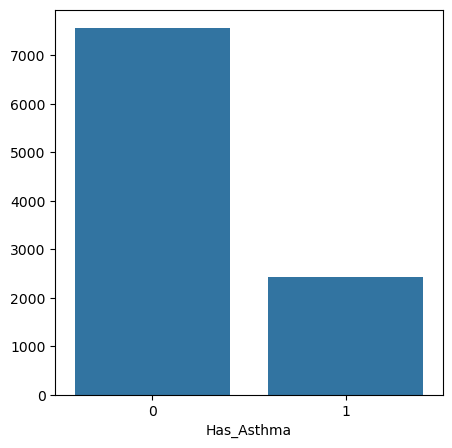

In [25]:
plt.figure(figsize=(5,5))
sns.barplot(x=target.index,y=target.values)
plt.show();

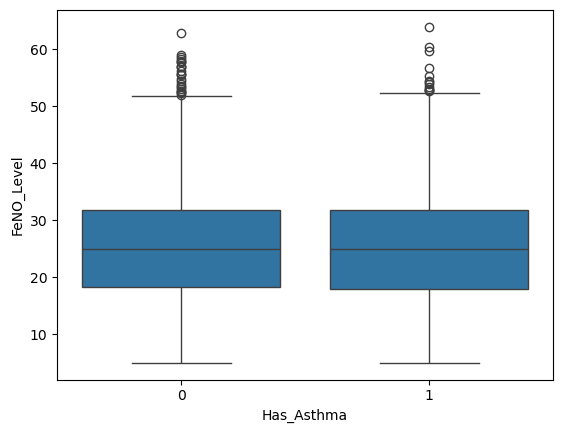

In [39]:
sns.boxplot(x='Has_Asthma',y='FeNO_Level',data=asthma)
plt.show()

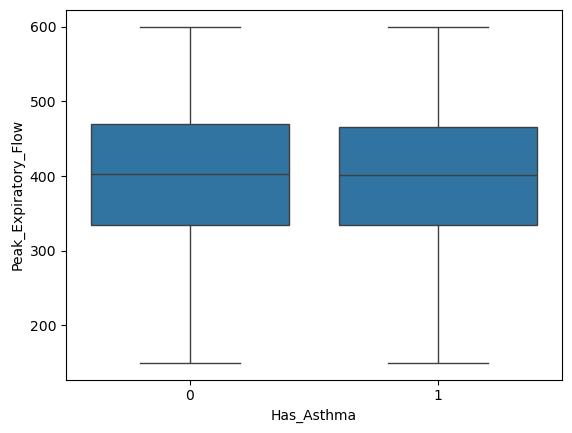

In [40]:
sns.boxplot(x='Has_Asthma',y='Peak_Expiratory_Flow',data=asthma)
plt.show()

In [36]:
pd.crosstab(asthma['Has_Asthma'],asthma['FeNO_Level'])

FeNO_Level,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,...,57.0,57.8,57.9,58.3,58.6,59.0,59.6,60.3,62.8,63.9
Has_Asthma,,,,,,,,,,,,,,,,,,,,,
0,181,3,5,2,3,2,6,8,4,2,...,1,2,1,1,1,1,0,0,1,0
1,38,1,3,2,2,0,2,1,1,0,...,0,0,0,0,0,0,1,1,0,1


In [38]:
pd.crosstab(asthma['Has_Asthma'],asthma['Peak_Expiratory_Flow'])

Peak_Expiratory_Flow,150.0,150.3,150.7,151.9,152.5,153.2,153.4,153.6,153.8,154.4,...,597.9,598.1,598.2,598.6,599.0,599.2,599.3,599.7,599.9,600.0
Has_Asthma,,,,,,,,,,,,,,,,,,,,,
0,49,1,1,1,1,1,1,1,1,0,...,1,1,0,1,1,1,1,1,1,176
1,18,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,1,1,66


In [27]:
asthma['Allergies'] = asthma['Allergies'].fillna('Unknown')
asthma['Comorbidities'] = asthma['Comorbidities'].fillna("None")


In [28]:
X=asthma.drop(['Patient_ID','Asthma_Control_Level','Has_Asthma'],axis=1)
y=asthma['Has_Asthma']

In [29]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns
num_cols = X.select_dtypes(include=[np.number]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

In [30]:
np.random.seed(42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [31]:
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])
log_reg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        random_state=42,
        use_label_encoder=False,   
        eval_metric="logloss"      
    ))
])
xgb.fit(X_train, y_train)

C:\Users\sktmb\Desktop\f1project\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Logistic Regression:")
evaluate_model(log_reg, X_test, y_test)

print("\nRandom Forest:")
evaluate_model(rf, X_test, y_test)

print("\nXGBClassifier:")
evaluate_model(xgb, X_test, y_test)

Logistic Regression:
Accuracy: 0.9885
Precision: 1.0
Recall: 0.9536290322580645
F1 Score: 0.9762641898864809
ROC-AUC: 0.9999798923301304

Random Forest:
Accuracy: 0.9955
Precision: 1.0
Recall: 0.9818548387096774
F1 Score: 0.9908443540183113
ROC-AUC: 0.9999946379547014

XGBClassifier:
Accuracy: 0.9995
Precision: 0.9979879275653923
Recall: 1.0
F1 Score: 0.998992950654582
ROC-AUC: 0.9999986594886754


In [42]:
model= xgb
importances= model.feature_importances_

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

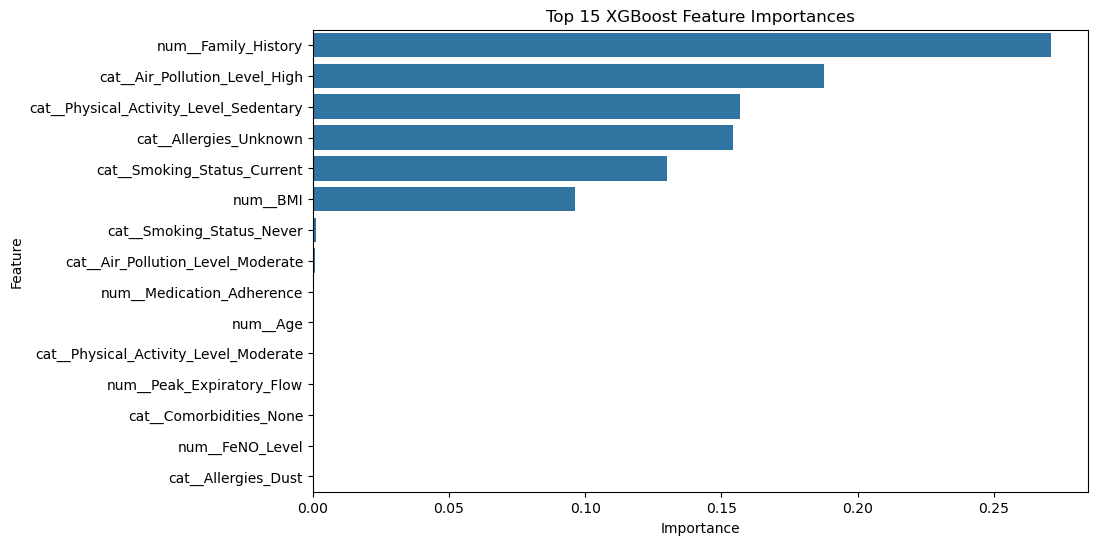

In [43]:
xgb_model = xgb.named_steps["model"]
importances = xgb_model.feature_importances_
features = preprocessor.get_feature_names_out()
imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(15))
plt.title("Top 15 XGBoost Feature Importances")
plt.show()

In [47]:
import joblib
joblib.dump(xgb, "asthma_model.pkl") 

['asthma_model.pkl']